### Build Our Model

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Uncompressed_" + dimention + ".npz"

# Load  compressed image matrix data
data = np.load(npzFileName)
ImageData_compressed = data['imageDatas_np']
print("=======done load======")

print(ImageData_compressed.shape)

=======done load======
(3410, 100, 100, 1)


## Data Preprocessing
### 1) center the char

In [5]:
def centerChar(Img):
    dimension = len(Img)
    location = locatChar(Img)
    
    resultImg = []
    for i in range(dimension):
        row = []
        for j in range(dimension):
            row += [[np.float32(1.0)]]
            
        resultImg += [row]
    
    offset_row = int((dimension-(location[1] + 1 -location[0]))/2)    
    offset_col = int((dimension-(location[3] + 1 -location[2]))/2)
    
    for i in range(0, location[1] + 1 - location[0]):
        for j in range(0, location[3] + 1 - location[2]):
            resultImg[i + offset_row][j + offset_col][0] = Img[i + location[0]][j + location[2]][0]
    
    
    resultImg = np.array(resultImg)
    return resultImg
    
def locatChar(Img):
    dimension = len(Img)
    top = dimension
    bottom = 0
    left = dimension
    right = 0
    
    for i in range(dimension):
        for j in range(dimension):
            if Img[i][j][0] < 0.2:
                if top > i:
                    top = i
                if bottom < i:
                    bottom = i
                if left > j:
                    left = j
                if right < j:
                    right = j
    return [top, bottom, left, right]

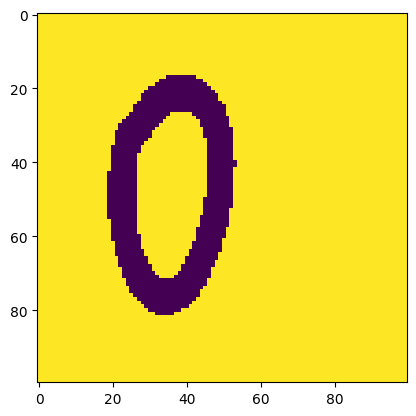

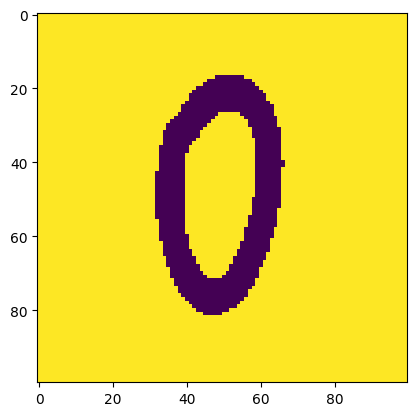

In [6]:
result = centerChar(ImageData_compressed[0])
plt.imshow(ImageData_compressed[0])
plt.show()
plt.imshow(result)
plt.show()

portion = (ImageData_compressed[0])[17:82, 19:54]
# plt.imshow(portion)
# plt.show()

In [7]:
# center all the data

ImageData_centered = []
count = 0
print("=====start processing=====")
for img in ImageData_compressed:
    img_c = centerChar(img)
    ImageData_centered += [img_c]
    
    count += 1
    if (count % 500 == 0):
        print("processed: ", count, " imgs" )

print("=====finish processing=====")

ImageData_centered = np.array(ImageData_centered)
print(ImageData_centered.shape)

=====start processing=====
processed:  500  imgs
processed:  1000  imgs
processed:  1500  imgs
processed:  2000  imgs
processed:  2500  imgs
processed:  3000  imgs
=====finish processing=====
(3410, 100, 100, 1)


In [5]:
import numpy
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Save compressed data to NPZ file
# numpy.savez(npzFileName, ImageData_centered=ImageData_centered)
# print("=======done saving======")

In [7]:
import numpy
import pandas as pd
import numpy as np

dataset = pd.read_csv('archive/english.csv')
directory = "archive"

imageDatas = []
files = dataset["image"]
label = dataset["label"]
dimention = "100x100"
npzFileName = "Centered_" + dimention + ".npz"

# Load  compressed image matrix data
data = numpy.load(npzFileName)
ImageData_centered = data['ImageData_centered']
print("=======done loading=======")

print(ImageData_centered.shape)

=======done loading=======
(3410, 100, 100, 1)


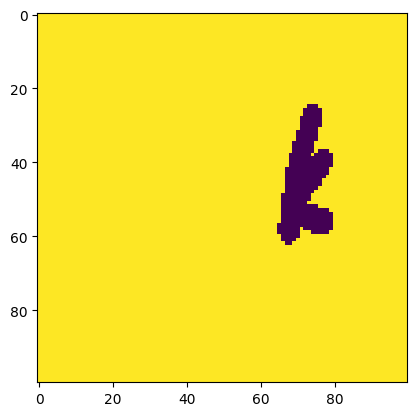

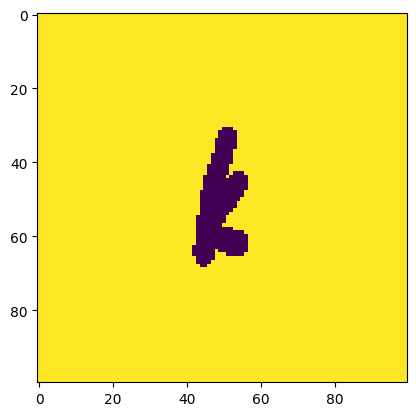

In [8]:
plt.imshow(ImageData_compressed[2578])
plt.show()
plt.imshow(ImageData_centered[2578])
plt.show()

In [9]:
def getIndex(letter):
    index = ord(letter)-48
    if (index > 10):
        index -= 7
    if (index > 35):
        index -= 6
    return index

In [10]:
import random

data_nparr = ImageData_centered
label_nparr = np.array(label)

test_index = []
# Randomly select 6 items from each group of 55
selected_indices = []
print(label_nparr.shape)
for i in range(0, len(label_nparr), 55):
    charGroup = data_nparr[i:i+55]
    indices = random.sample(range(i, i+55), 10)
    test_index.extend(indices)

test_index_nparr = np.array(test_index)
print(test_index_nparr.shape)

train_data, test_data, train_label, test_label = [], [], [], []
for i in range(len(label_nparr)):
    if i in test_index:
        test_data += [data_nparr[i]]
        test_label += [getIndex(label_nparr[i])]
    else:
        train_data += [data_nparr[i]]
        train_label += [getIndex(label_nparr[i])]

train_data = np.array(train_data)
test_data = np.array(test_data)
train_label = np.array(train_label)
test_label = np.array(test_label)

train_label_onehot = pd.get_dummies(train_label) # one-hot enc
test_label_onehot = pd.get_dummies(test_label) # one-hot enc

print(train_data.shape)

(3410,)
(620,)
(2790, 100, 100, 1)


In [94]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from PIL import Image

def apply_rotation_augmentation(images):
    # Convert the images to TensorFlow tensors
    images_tensor = tf.convert_to_tensor(images)

    # Reshape the images tensor to (some_amount, height, width, channels)
    images_tensor = tf.reshape(images_tensor, [len(images), 100, 100, 1])

    # Generate random rotation angles between -5 and 5 degrees for each image
    rotation_angles = tf.random.uniform(shape=[len(images)], minval=-10, maxval=10)

    # Apply rotation augmentation and resize to each image
    rotated_images = []
    for i in range(len(images)):
        img = tf.keras.preprocessing.image.array_to_img(images_tensor[i])
        img = img.rotate(rotation_angles[i])
        img = img.resize((116, 116), resample=Image.NEAREST)
        img = img.crop((8, 8, 108, 108)) 
        rotated_img = tf.keras.preprocessing.image.img_to_array(img)
        rotated_images.append(rotated_img)
    
    rotated_images = tf.convert_to_tensor(rotated_images)

    return rotated_images

In [95]:
train_data_augmented = train_data
print("=============Start Augmentation=============")
for i in range(5):
    train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[i * 500:(i + 1) * 500])), axis=0)
    print("processed ", (i + 1) * 500, " Img")
    
train_data_augmented = np.concatenate((train_data_augmented, apply_rotation_augmentation(train_data[2500:2790])), axis=0)
print("=============Finish Augmentation=============")
print(train_data_augmented.shape)

=============Start Augmentation=============
processed  500  Img
processed  1000  Img
processed  1500  Img
processed  2000  Img
processed  2500  Img
=============Finish Augmentation=============
(5580, 100, 100, 1)


In [96]:
train_label_augmented = np.concatenate((train_label, train_label), axis=0)
train_label_augmented_onehot = pd.get_dummies(train_label_augmented)
print(train_label.shape)
print(train_label_augmented_onehot.shape)

(2790,)
(5580, 62)


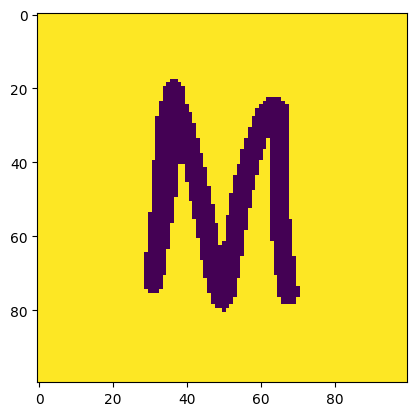

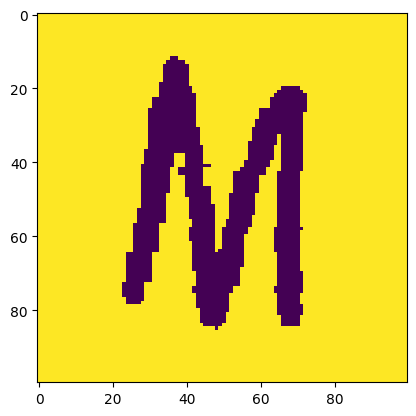

In [97]:
index_check = 1000;
plt.imshow(train_data_augmented[index_check])
plt.show()
plt.imshow(train_data_augmented[index_check + 2790])
plt.show()

In [98]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers

print("Input shape:", data_nparr[0].shape)

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=data_nparr[0].shape, kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(62, activation='softmax'))

print("Layers added")
model.summary()

Input shape: (100, 100, 1)
Layers added
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 23, 23, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 21, 21, 128)       73856     
                                                                 
 max_pooling2d

In [99]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("======start training======")
history = model.fit(train_data_augmented, train_label_augmented_onehot, epochs=15, 
                    validation_data=(test_data, test_label_onehot))
print("======done training======")

======start training======
Epoch 1/15
175/175 [==============================] - 25s 141ms/step - loss: 11.2314 - accuracy: 0.2620 - val_loss: 8.3191 - val_accuracy: 0.2419
Epoch 2/15
175/175 [==============================] - 25s 142ms/step - loss: 5.5360 - accuracy: 0.5332 - val_loss: 4.7965 - val_accuracy: 0.5726
Epoch 3/15
175/175 [==============================] - 25s 145ms/step - loss: 3.6721 - accuracy: 0.6849 - val_loss: 3.5315 - val_accuracy: 0.6145
Epoch 4/15
175/175 [==============================] - 25s 144ms/step - loss: 2.7770 - accuracy: 0.7425 - val_loss: 2.7939 - val_accuracy: 0.6758
Epoch 5/15
175/175 [==============================] - 26s 146ms/step - loss: 2.2002 - accuracy: 0.7780 - val_loss: 2.3964 - val_accuracy: 0.6952
Epoch 6/15
175/175 [==============================] - 25s 145ms/step - loss: 1.8346 - accuracy: 0.7996 - val_loss: 2.1021 - val_accuracy: 0.6855
Epoch 7/15
175/175 [==============================] - 25s 144ms/step - loss: 1.5877 - accuracy: 0.8100

In [101]:
# save model
model.save('../CNN_ver9_augmented.h5')
print("======model saved======")

======model saved======


20/20 - 1s - loss: 1.4377 - accuracy: 0.7597 - 529ms/epoch - 26ms/step


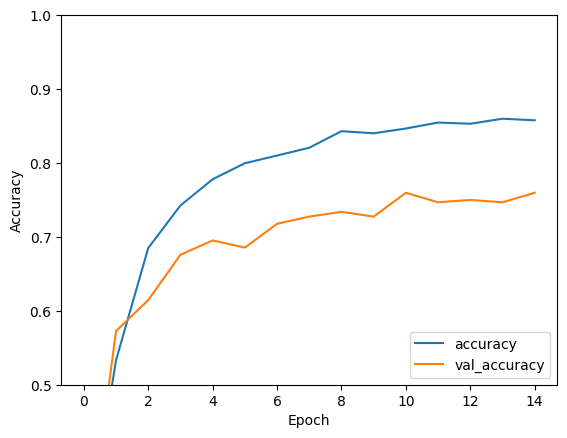

In [100]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_data,  test_label_onehot, verbose=2)

In [130]:
print(test_acc)

0.7806451320648193


In [102]:
from sklearn.metrics import classification_report

# Function to convert one-hot encoded label to label index
def get_result(prob_array):
    return np.argmax(prob_array)

test_pred = model.predict(test_data)
test_result = np.apply_along_axis(get_result, axis=1, arr=test_pred)


class_names = ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
class_names = class_names[0]

print(classification_report(test_label, test_result, target_names=class_names,  zero_division=1))

20/20 [==============================] - 1s 25ms/step
              precision    recall  f1-score   support

           0       0.26      0.60      0.36        10
           1       0.82      0.90      0.86        10
           2       1.00      0.60      0.75        10
           3       0.83      1.00      0.91        10
           4       0.80      0.80      0.80        10
           5       0.83      0.50      0.62        10
           6       1.00      0.90      0.95        10
           7       1.00      0.90      0.95        10
           8       1.00      0.40      0.57        10
           9       0.75      0.60      0.67        10
           A       1.00      1.00      1.00        10
           B       0.54      0.70      0.61        10
           C       0.91      1.00      0.95        10
           D       0.89      0.80      0.84        10
           E       0.90      0.90      0.90        10
           F       1.00      0.90      0.95        10
           G       1.00    

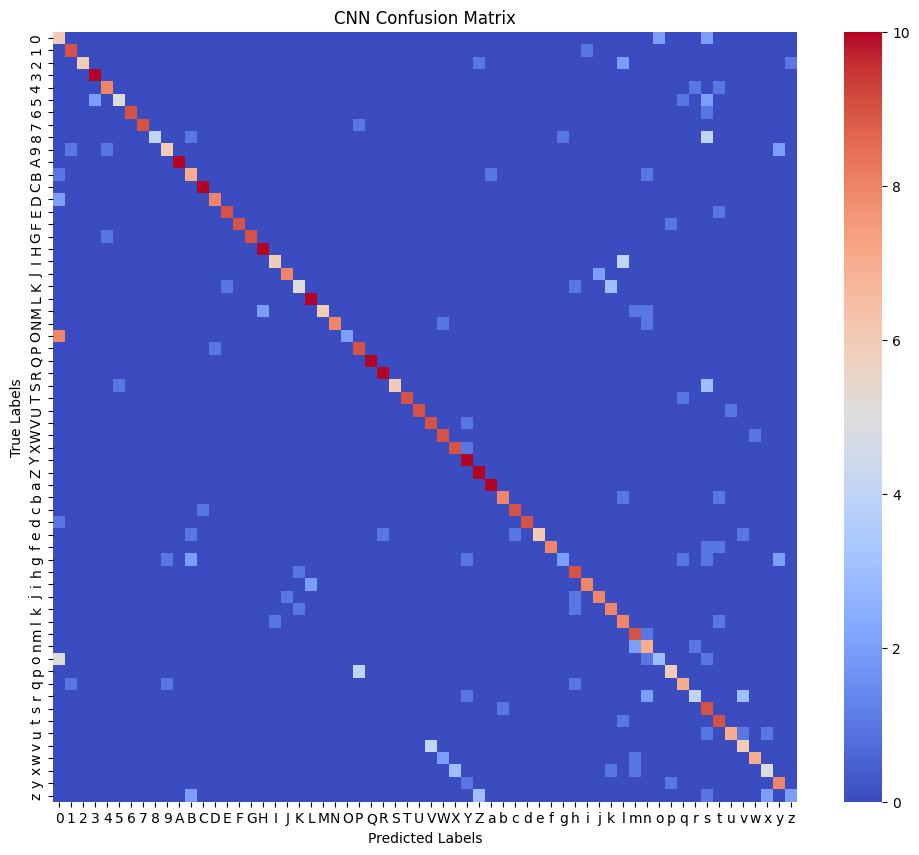

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_label, test_result)


# Plot the confusion matrix as a heat map
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="coolwarm", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("CNN Confusion Matrix")
plt.show()

In [105]:
# calculate results
Result = []
oneCharResult = []
test_size = 10 # per char
# initialize
for letter in range(len(class_names)):
    oneCharResult = []
    for predicte in range(len(class_names)):
        oneCharResult += [0]
    Result +=[oneCharResult]

    
for i in range(len(test_label)):
    pred = test_result[i]
    actual = test_label[i]
    
    
    if pred != actual:
        actualLetter = int(i/test_size)
        Result[actualLetter][pred] = Result[actualLetter][pred] + 1


falsePredict = []

print("Each char has total 6 test image data")
for letter in range(len(class_names)):
    haveNotPrintLetter = 1
    for p in range(len(class_names)):
        if Result[letter][p] >= 1:
            if haveNotPrintLetter == 1:
                print("Letter :", class_names[letter])
                haveNotPrintLetter = 0
            print("   - mispredict: [", class_names[p], "] ",Result[letter][p])
        
    falsePredict += [np.sum(Result[letter])]
    
print(falsePredict)

Each char has total 6 test image data
Letter : 0
   - mispredict: [ o ]  2
   - mispredict: [ s ]  2
Letter : 1
   - mispredict: [ i ]  1
Letter : 2
   - mispredict: [ Z ]  1
   - mispredict: [ l ]  2
   - mispredict: [ z ]  1
Letter : 4
   - mispredict: [ r ]  1
   - mispredict: [ t ]  1
Letter : 5
   - mispredict: [ 3 ]  2
   - mispredict: [ q ]  1
   - mispredict: [ s ]  2
Letter : 6
   - mispredict: [ s ]  1
Letter : 7
   - mispredict: [ P ]  1
Letter : 8
   - mispredict: [ B ]  1
   - mispredict: [ g ]  1
   - mispredict: [ s ]  4
Letter : 9
   - mispredict: [ 1 ]  1
   - mispredict: [ 4 ]  1
   - mispredict: [ y ]  2
Letter : B
   - mispredict: [ 0 ]  1
   - mispredict: [ a ]  1
   - mispredict: [ n ]  1
Letter : D
   - mispredict: [ 0 ]  2
Letter : E
   - mispredict: [ t ]  1
Letter : F
   - mispredict: [ p ]  1
Letter : G
   - mispredict: [ 4 ]  1
Letter : I
   - mispredict: [ l ]  4
Letter : J
   - mispredict: [ j ]  2
Letter : K
   - mispredict: [ E ]  1
   - mispredict: [ h 